In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import dir_constants as dc
from tqdm import tqdm
from j_utils import munging as mg
from j_utils import eval_results as er
import lc_utils
# from fastai.structured import *

pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999
pd.options.display.max_seq_items = None
# np.set_printoptions(threshold=100)

In [3]:
PATH = dc.data_path
project = 'lendingclub'
fname_base_loan = 'base_loan_info.fth'
fname_eval_loan = 'eval_loan_info.fth'
fname_str_loan = 'str_loan_info.fth'
fname_scl_pmt = 'scaled_pmt_hist.fth'
data_path = f'{PATH}{project}'

In [4]:
# load in and drop fico low
base_loan_info = pd.read_feather(f'{data_path}/base_loan_info.fth')
base_loan_info.drop('fico_range_low', axis=1, inplace=True)
eval_loan_info = pd.read_feather(f'{data_path}/eval_loan_info.fth')
str_loan_info = pd.read_feather(f'{data_path}/str_loan_info.fth')
# base_loan_info = pd.read_feather(f'{data_path}/base_loan_info_w_newfeats.fth')

In [6]:
print(base_loan_info.shape)
lc_utils.add_custom_lc_features(base_loan_info)
print(base_loan_info.shape)

(2003915, 102)
(2003915, 107)


```
In this notebook I want to determine how I should evaluate models. Previously, I trained regressors on data to predict a npv_return on loans.
Things I want to determine:
1) Should I use ranking as a target? e.g. see loans in a batch, rank loans by known return, and then have model try and be good at ranking loans within batches?
1a) The final loan selection should probably determine a rank and regress a return, so we can still select a minimum score threshold that a loan must have a predicted return greater than before investing in it.
2) I want to do some sort of testing to see whether I should actually be training on all my data. Compare the following scenarios where "today" is a chosen date in the past and "prev" is a date older than "today":
    train on all past until today, test on everything in future (see how good past can predict future, pushing "today" more into the past will show us how good "old models" are still beyond their today)
    train on all past until today, test on sequential 3-mo periods in future (can show us if predictions get steadily worse as we move further and further past "today")
    train from prev until today, test on everything beyond today (see if its actually better to not use all the old data)
    train from prev until today, test on sequential 3-mo periods in future (more distinction between train on all data or train on relevant data)
```

In [7]:
def check_date_doneness(eval_loan_info):
    '''Every month, get all loans that were issued on or before month and ended on or after month (all loans that were alive during month, DENOMINATOR) and how many of those loans are still alive today (NUMERATOR, filter by status not in ['paid', 'charged_off', 'defaulted])'''
    dates = sorted(list(set(eval_loan_info['issue_d'].unique()).union(set(eval_loan_info['end_d'].unique()))))
    res_dict = {}
    for month in tqdm(dates):
        alive_cond = (eval_loan_info['issue_d'] <= month) & (eval_loan_info['end_d'] >= month)
        alive_in_month = eval_loan_info[alive_cond]
        still_going_today = alive_in_month[~alive_in_month['loan_status'].isin(['paid', 'defaulted', 'charged_off'])]
        res_dict[month] = len(still_going_today)/len(alive_in_month)
    return pd.Series(res_dict)

100%|██████████| 138/138 [00:13<00:00,  3.80it/s]


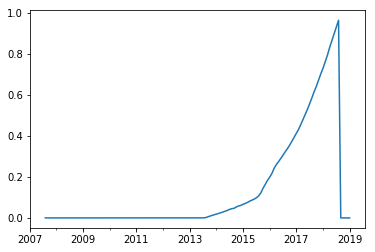

In [8]:
res = check_date_doneness(eval_loan_info=eval_loan_info)
res.plot()

In [10]:
# oldness_thrsh = .9
dates = sorted(list(set(eval_loan_info['issue_d'].unique()).union(set(eval_loan_info['end_d'].unique()))))
start_date = '2011-01-01'

In [11]:
base_loan_info, eval_loan_info = lc_utils.split_out_traintestable_loans(base_loan_info, eval_loan_info)

In [12]:
print(base_loan_info.shape, eval_loan_info.shape)

(1151168, 107) (1151168, 43)


In [10]:
def run_expt(today, oldest, valid_start, base_loan_info, eval_loan_info, valid_end=None):
    train_ids = eval_loan_info[(eval_loan_info['issue_d'] <= today) & (eval_loan_info['issue_d'] >= oldest)]['id'].unique()
    if valid_end:
        valid_ids = eval_loan_info[(eval_loan_info['issue_d'] >= valid_start) & (eval_loan_info['issue_d'] <= valid_end)]['id'].unique()
    else:
        valid_ids = eval_loan_info[(eval_loan_info['issue_d'] >= valid_start)]['id'].unique()
    train = base_loan_info[base_loan_info['id'].isin(train_ids)]
    valid = base_loan_info[base_loan_info['id'].isin(valid_ids)]
    
    # setup for catboost
    # a bit more data processing and nan handling for catboost
    X_train = train.copy()
    X_train, na_map = mg.get_medians_make_nullcols_fill_values(X_train, catboost=True)
    
    X_valid = valid.copy()
    X_valid = mg.get_medians_make_nullcols_fill_values(valid, na_map, catboost=True)
    return X_train, X_valid, na_map

In [11]:
today = pd.to_datetime('2013-01-01')
oldest = eval_loan_info['issue_d'].min()
valid_start = pd.to_datetime(today) + pd.DateOffset(months=1)

In [12]:
ex = run_expt(today, oldest, valid_start, base_loan_info, eval_loan_info)

100%|██████████| 78/78 [00:00<00:00, 632.54it/s]

is_inc_v_joint col is likely of non-int/float dtype, filling with mode instead
emp_length col is likely of non-int/float dtype, filling with mode instead



/home/justin/j_utils/munging.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].fillna(nafill)


Was passed an na_map. Will fill accordingly (test or valid data?


In [14]:
mg.no_nulls(ex[0]) == mg.no_nulls(ex[1])

False

In [16]:
mg.no_nulls(ex[0])

True

In [17]:
mg.no_nulls(ex[1])

False

In [20]:
has_nulls = [col for col in ex[1].columns if any(ex[1][col].isnull())]
has_nulls

['dti', 'dti_w_loan', 'delinq_to_monthly_inc']

In [19]:
ex[2]

{'acc_open_past_24_mths': 3.0,
 'all_util': 0,
 'annual_inc_joint': 0,
 'avg_cur_bal': 7081.0,
 'bc_open_to_buy': 3328.0,
 'bc_util': 0.731,
 'dti_joint': 0,
 'emp_length': '10+ years',
 'i_l_util': 0,
 'inq_fi': 0,
 'inq_last_12m': 0,
 'is_inc_v_joint': 'nan',
 'max_bal_bc': 0,
 'mo_sin_old_il_acct': 126.0,
 'mo_sin_old_rev_tl_op': 157.0,
 'mo_sin_rcnt_rev_tl_op': 9.0,
 'mo_sin_rcnt_tl': 6.0,
 'mort_acc': 1.0,
 'mths_since_last_delinq': 34.0,
 'mths_since_last_major_derog': 40.0,
 'mths_since_last_record': 90.0,
 'mths_since_rcnt_il': 0,
 'mths_since_recent_bc': 14.0,
 'mths_since_recent_bc_dlq': 40.0,
 'mths_since_recent_inq': 5.0,
 'mths_since_recent_revol_delinq': 36.0,
 'num_accts_ever_12_0_ppd': 0.0,
 'num_actv_bc_tl': 3.0,
 'num_actv_rev_tl': 5.0,
 'num_bc_sats': 4.0,
 'num_bc_tl': 8.0,
 'num_il_tl': 6.0,
 'num_op_rev_tl': 7.0,
 'num_rev_accts': 14.0,
 'num_rev_tl_bal_gt_0': 5.0,
 'num_sats': 10.0,
 'num_tl_12_0dpd_2m': 0.0,
 'num_tl_30dpd': 0.0,
 'num_tl_90g_dpd_24m': 0.0,
 'nu

In [17]:
base_loan_info.shape

(1151168, 131)

In [18]:
eval_loan_info.shape

(1151168, 43)

# Old stuff from baseline_models

In [ ]:
# Old stuff
# platform = 'lendingclub'

# store = pd.HDFStore(
#     '/Users/justinhsi/justin_tinkering/data_science/lendingclub/{0}_store.h5'.
#     format(platform),
#     append=True)

# test = store['test_filtered_columns']
# loan_npv_rois = store['loan_npv_rois']
# default_series = test['target_strict']

In [ ]:
def basic_models(trials, port_size, available_loans, grade, test,
                 loan_npv_rois, default_series):
    results = {}
    pct_default = {}
    if grade:
        test = test[test['grade'] == grade]
    for trial in tqdm_notebook(np.arange(trials)):
        loans_to_pick_from = np.random.choice(
            test.index.values, available_loans, replace=False)
        picks = np.random.choice(loans_to_pick_from, port_size, replace=False)
        results[trial] = loan_npv_rois.loc[picks, :].mean().to_dict()
        pct_default[trial] = (default_series.loc[picks].sum()) / port_size
    pct_default_series = pd.Series(pct_default)
    results_df = pd.DataFrame(results).T
    results_df['pct_def'] = pct_default_series
#     if not grade:
#         results_df = results_df.add_prefix('baseline_')
#     else:
#         results_df = results_df.add_prefix(grade + '_')
    if not grade:
        grade = 'baseline'
    results_df.columns = zip(results_df.columns.values,[grade]*len(results_df.columns.values))
    return results_df

In [ ]:
grades = [None]
grades.extend(test.grade.unique().tolist())
grades.sort()
grade_counts = test.grade.value_counts(dropna=False)

In [ ]:
trials = 20000
available_loans = 3000
grades_available_loans = [
    int(min(grade_counts[grade] * .2, available_loans))
    if grade else available_loans for grade in grades
]
grades_port_size = [int(.3*n_loans) for n_loans in grades_available_loans]
grade_batch_loans = dict(zip(grades, zip(grades_available_loans,grades_port_size)))

In [ ]:
grade_batch_loans

In [ ]:
grades_port_size

In [ ]:
results_dict = {}
for grade in tqdm_notebook(grades):
    results_dict[grade] = basic_models(trials, grade_batch_loans[grade][1],
                                       grade_batch_loans[grade][0], grade,
                                       test, loan_npv_rois, default_series)

In [ ]:
result = pd.concat(results_dict.values(), axis=1)
result.columns = pd.MultiIndex.from_tuples(
    result.columns.values, names=['discount_rate', 'model'])
result.sort_index(axis=1, inplace = True)

In [ ]:
result.describe()

In [ ]:
store.open()
store['results'] = result
store.close()